# Análise de Indicadores de Endividamento

In [22]:
import os
import re
import unidecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import scipy.stats as stats

plt.style.use('seaborn')
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "14"

In [2]:
def secure_name(string):
    """
    Remove caracteres especiais de uma string
    """
    pattern = r'[^A-Za-z0-9_]+'
    output_string = string.replace(' ', '_').lower()
    output_string = unidecode.unidecode(output_string)
    output_string = re.sub(pattern, '', output_string)
    return output_string

In [3]:
ROOT_DIR = os.getcwd().replace('src', '')

In [4]:
novo_mercado = pd.read_csv(os.path.join(ROOT_DIR, 'data', 'sample_market-2022-09-15.csv'))
novo_mercado.head()

,Nome Do Pregão,Código,Denominação Social,Segmento De Mercado,Tipo De Capital,Capital R$,Aprovado Em,Qtde Ações Ordinárias,Qtde Ações Preferenciais,Qtde Total De Ações,CNPJ,Código CVM,Ticker,Atividade Principal,Setor Econômico,Subsetor Econômico,Segmento Econômico,Site,Url
0,ATMASA,ATMP,ATMA PARTICIPAÇÕES S.A.,NOVO MERCADO,Homologado,1.419403e+09,15/12/2021,26710356,0,26710356,04.032.433/0001-80,19100,ATMP3.SA,A ATMA Participações S.A. tem como objeto soci...,Bens Industriais,Serviços,Serviços Diversos,www.liq.com.br,https://sistemaswebb3-listados.b3.com.br/liste...
1,CCR SA,CCRO,CCR S.A.,NOVO MERCADO,Homologado,6.126100e+09,09/02/2017,2020000000,0,2020000000,02.846.056/0001-97,18821,CCRO3.SA,Prestadora de serviços públicos por meio de co...,Bens Industriais,Transporte,Exploração de Rodovias,www.ccr.com.br,https://sistemaswebb3-listados.b3.com.br/liste...
2,ECORODOVIAS,ECOR,ECORODOVIAS INFRAESTRUTURA E LOGÍSTICA S.A.,NOVO MERCADO,Homologado,2.101489e+09,23/06/2021,696334224,0,696334224,04.149.454/0001-80,19453,ECOR3.SA,Exploração direta ou indireta de negócios de c...,Bens Industriais,Transporte,Exploração de Rodovias,www.ecorodovias.com.br,https://sistemaswebb3-listados.b3.com.br/liste...
3,EMBRAER,EMBR,EMBRAER S.A.,NOVO MERCADO,Homologado,5.159617e+09,05/03/2018,740465044,0,740465044,07.689.002/0001-89,20087,EMBR3.SA,Projeto. desenvolvimento. fabricação. comercia...,Bens Industriais,Material de Transporte,Material Aeronáutico e de Defesa,www.embraer.com.br,https://sistemaswebb3-listados.b3.com.br/liste...
4,ETERNIT,ETER,ETERNIT S.A.,NOVO MERCADO,Homologado,4.380815e+08,29/09/2021,61776575,0,61776575,61.092.037/0001-81,5762,ETER3.SA,Industrialização e comercialização de produtos...,Bens Industriais,Construção e Engenharia,Produtos para Construção,www.eternit.com.br/ri,https://sistemaswebb3-listados.b3.com.br/liste...


In [5]:
setores = novo_mercado['Setor Econômico'].drop_duplicates().to_list()
setores

['Bens Industriais',
 'Comunicações',
 'Consumo Cíclico',
 'Consumo não Cíclico',
 'Financeiro',
 'Materiais Básicos',
 'Petróleo. Gás e Biocombustíveis',
 'Saúde',
 'Tecnologia da Informação',
 'Utilidade Pública']

In [6]:
dfcs_nomes = ['BPA_con', 'BPP_con', 'DRE_con']
dfcs = pd.DataFrame()
for nome in dfcs_nomes:
    for tipo in ['itr', 'dfp']:
        tmp = pd.read_csv(os.path.join(ROOT_DIR, 'data', 'dfcs', f'{tipo}_cia_aberta_{nome}_2017-2021.csv'))
        dfcs = pd.concat([dfcs, tmp])
    
dfcs = dfcs[dfcs['ORDEM_EXERC']=='ÚLTIMO']
dfcs = dfcs[['DT_REFER', 'DENOM_CIA', 'CNPJ_CIA', 'CD_CVM', 'CD_CONTA', 'DS_CONTA', 'VL_CONTA']]
dfcs['DT_REFER'] = pd.to_datetime(dfcs['DT_REFER'])
dfcs = dfcs[dfcs['CD_CONTA'].apply(lambda x: len(x) <= 10)]
dfcs.reset_index(drop=True, inplace=True)
dfcs = dfcs.sort_values(['DENOM_CIA', 'DT_REFER'])
dfcs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1204819 entries, 251943 to 1195523
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   DT_REFER   1204819 non-null  datetime64[ns]
 1   DENOM_CIA  1204819 non-null  object        
 2   CNPJ_CIA   1204819 non-null  object        
 3   CD_CVM     1204819 non-null  int64         
 4   CD_CONTA   1204819 non-null  object        
 5   DS_CONTA   1204819 non-null  object        
 6   VL_CONTA   1204819 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 73.5+ MB


In [7]:
dfcs.head()

,DT_REFER,DENOM_CIA,CNPJ_CIA,CD_CVM,CD_CONTA,DS_CONTA,VL_CONTA
251943,2019-12-31,2W ENERGIA S.A.,08.773.135/0001-00,25224,1,Ativo Total,424330.0
251944,2019-12-31,2W ENERGIA S.A.,08.773.135/0001-00,25224,1.01,Ativo Circulante,286849.0
251945,2019-12-31,2W ENERGIA S.A.,08.773.135/0001-00,25224,1.01.01,Caixa e Equivalentes de Caixa,11588.0
251946,2019-12-31,2W ENERGIA S.A.,08.773.135/0001-00,25224,1.01.02,Aplicações Financeiras,0.0
251947,2019-12-31,2W ENERGIA S.A.,08.773.135/0001-00,25224,1.01.02.01,Aplicações Financeiras Avaliadas a Valor Justo...,0.0


In [8]:
dfcs.tail()

,DT_REFER,DENOM_CIA,CNPJ_CIA,CD_CVM,CD_CONTA,DS_CONTA,VL_CONTA
1195519,2021-12-31,ZAMP SA,13.574.594/0001-96,24317,3.99,Lucro por Ação - (Reais / Ação),0.00000
1195520,2021-12-31,ZAMP SA,13.574.594/0001-96,24317,3.99.01,Lucro Básico por Ação,0.00000
1195521,2021-12-31,ZAMP SA,13.574.594/0001-96,24317,3.99.01.01,ON,-0.99893
1195522,2021-12-31,ZAMP SA,13.574.594/0001-96,24317,3.99.02,Lucro Diluído por Ação,0.00000
1195523,2021-12-31,ZAMP SA,13.574.594/0001-96,24317,3.99.02.01,ON,-0.99893


## Indicadores de Endividamento

* Relação Capital de Terceiros/Capital Próprio $$RCT/CP = \dfrac{Exigível\ Total}{Patrimônio\ Líquido}$$

* Relação Capital de Terceiros/Passivo Total $$RCT/CP = \dfrac{Exigível\ Total}{Passivo\ Total}$$ 

In [9]:
contas = dfcs[dfcs['CD_CVM']==25224]
contas = contas[['CD_CONTA', 'DS_CONTA']].drop_duplicates()

In [10]:
display(contas[:51])
display(contas[51:100])
display(contas[100:])

,CD_CONTA,DS_CONTA
251943,1,Ativo Total
251944,1.01,Ativo Circulante
251945,1.01.01,Caixa e Equivalentes de Caixa
251946,1.01.02,Aplicações Financeiras
251947,1.01.02.01,Aplicações Financeiras Avaliadas a Valor Justo...
251948,1.01.02.02,Aplicações Financeiras Avaliadas a Valor Justo...
251949,1.01.02.03,Aplicações Financeiras Avaliadas ao Custo Amor...
251950,1.01.03,Contas a Receber
251951,1.01.03.01,Clientes
251952,1.01.03.02,Outras Contas a Receber


,CD_CONTA,DS_CONTA
737805,2.01.03.02,Obrigações Fiscais Estaduais
737806,2.01.03.03,Obrigações Fiscais Municipais
737807,2.01.04,Empréstimos e Financiamentos
737808,2.01.04.01,Empréstimos e Financiamentos
737809,2.01.04.02,Debêntures
737810,2.01.04.03,Financiamento por Arrendamento
737811,2.01.05,Outras Obrigações
737812,2.01.05.01,Passivos com Partes Relacionadas
737813,2.01.05.02,Outros
737814,2.01.06,Provisões


,CD_CONTA,DS_CONTA
737854,2.03.04.02,Reserva Estatutária
737855,2.03.04.03,Reserva para Contingências
737856,2.03.04.04,Reserva de Lucros a Realizar
737857,2.03.04.05,Reserva de Retenção de Lucros
737858,2.03.04.06,Reserva Especial para Dividendos Não Distribuídos
737859,2.03.04.07,Reserva de Incentivos Fiscais
737860,2.03.04.08,Dividendo Adicional Proposto
737861,2.03.04.09,Ações em Tesouraria
737862,2.03.05,Lucros/Prejuízos Acumulados
737863,2.03.06,Ajustes de Avaliação Patrimonial


In [11]:
def calcula_endividamento(x):
    ET = x[x['CD_CONTA']=='2.01'].iloc[0]['VL_CONTA'] +  x[x['CD_CONTA']=='2.02'].iloc[0]['VL_CONTA'] # Exigível Total
    PL = x[x['CD_CONTA']=='2.03'].iloc[0]['VL_CONTA'] # Patrimônio Lóquido
    PT = ET + PL # Passivo Total

    
    RCT_CP = ET / PL # Relação Capital de Terceiros/Capital Próprio
    RCT_PT = ET / PT # Relação Capital de Terceiros/Passivo Total
    
    return pd.Series([RCT_CP, RCT_PT], index=['RCT/CP', 'RCT/PT'])
    

In [12]:
def calcula_endividamento_setorial(dfcs, setor, nome=None):
    endividamento_empresas = {}

    for cd_cvm in setor['Código CVM'].to_list():
        try:
            empresa = dfcs[dfcs['CD_CVM']==cd_cvm].reset_index(drop=True)
            if nome=='Comunicações':#17639 -> Tim participações
                empresa = dfcs[dfcs['CD_CVM'].isin([cd_cvm, 17639])].reset_index(drop=True)
            empresa = empresa[empresa['CD_CONTA'].apply(lambda x: len(x) <= 10)]
            endividamento = empresa.groupby('DT_REFER').apply(calcula_endividamento)
            endividamento.index = pd.PeriodIndex(endividamento.index, freq='Q')
            endividamento_empresas[cd_cvm] = endividamento
        except:
            endividamento_empresas[cd_cvm] = pd.DataFrame()

    endividamento_setorial = pd.DataFrame()
    for cd_cvm, endividamento in endividamento_empresas.items():
        peso = setor[setor['Código CVM']==cd_cvm]['Peso Capital Social'].reset_index(drop=True)
        peso = peso[0]
        endividamento_setorial = endividamento_setorial.add(peso * endividamento, fill_value=0)
        
    endividamento_setorial.to_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'endividamento_{secure_name(nome)}.csv'))

    return endividamento_setorial

In [13]:
def plot_endividamento(endividamento_setorial, nome=None):
    endividamento_setorial = endividamento_setorial['2018-01-01':]
    tidy = pd.melt(endividamento_setorial.reset_index(), id_vars='DT_REFER', value_vars=['RCT/CP', 'RCT/PT'])
    tidy.columns=['Trimestre', 'Endividamento', 'Valor']

    fig, ax = plt.subplots(figsize=(20, 6))
    sns.barplot(data=tidy, x='Trimestre', y='Valor', hue='Endividamento', ax=ax)
    #ax.set_ylim([int(endividamento_setorial.min().min()) - 1, 1.5 + int(endividamento_setorial.max().max())])

    ax.set_ylabel('Endividamento', fontweight='bold')
    ax.set_xlabel('Trimestre', fontweight='bold')
    
    plt.savefig(os.path.join(ROOT_DIR, 'img', 'indicadores', f'endividamento_{secure_name(nome)}.png'), bbox_inches='tight')

    plt.show()

In [14]:
def calcula_endividamento_testes(endividamento_setorial, nome=None):
    endividamento_setorial = endividamento_setorial['2018-01-01':]
    endividamento_prepandemia = endividamento_setorial[:'2019-12-31']
    endividamento_pandemia = endividamento_setorial['2020-01-01':]

    endividamento_prepandemia_stats = endividamento_prepandemia.describe().drop(['count'], axis=0)
    print('Estatísticas Descritivas - Pré-pandemia')
    display(endividamento_prepandemia_stats)
    endividamento_prepandemia_stats.to_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'endividamento_{secure_name(nome)}_prepandemia_stats.csv'))
    
    
    endividamento_pandemia_stats = endividamento_pandemia.describe().drop(['count'], axis=0)
    endividamento_pandemia_stats.to_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'endividamento_{secure_name(nome)}_pandemia_stats.csv'))
    print('Estatísticas Descritivas - Pandemia')
    display(endividamento_pandemia_stats)
    
    
    cols = ['Endividamento', 'Teste', 'Estatística', 'Valor p']
    endividamento_stats = pd.DataFrame(columns=cols)
    for endiv in endividamento_setorial.columns:

        group1, group2 = endividamento_prepandemia[endiv].to_numpy(), endividamento_pandemia[endiv].to_numpy()
        ttest= stats.ttest_ind(a=group1, b=group2)
        htest = stats.kruskal(group1, group2)

        dft = pd.DataFrame([endiv, 'Teste t', ttest.statistic, ttest.pvalue]).T
        dfh = pd.DataFrame([endiv, 'Teste H', htest.statistic, htest.pvalue]).T

        dft.columns = cols
        dfh.columns = cols

        endividamento_stats = pd.concat([endividamento_stats, dft, dfh])

    endividamento_stats.reset_index(drop=True, inplace=True)
    endividamento_stats.to_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'endividamento_{secure_name(nome)}_testes.csv'), index=False)
    
    return endividamento_stats

In [25]:
def calcula_endividamento_teste_amostral(endividamento_setorial, nome=None):
    endividamento_setorial = endividamento_setorial['2018-01-01':]
    endividamento_prepandemia = endividamento_setorial[:'2019-12-31']
    endividamento_pandemia = endividamento_setorial['2020-01-01':]
    
    RCT_CP_prepandemia = np.array([np.mean(np.random.choice(endividamento_prepandemia['RCT/CP'].to_numpy(), 4)) for _ in range(50)])
    RCT_PT_prepandemia = np.array([np.mean(np.random.choice(endividamento_prepandemia['RCT/PT'].to_numpy(), 4)) for _ in range(50)])
    endividamento_prepandemia = pd.DataFrame(list(zip(RCT_CP_prepandemia, RCT_PT_prepandemia)), columns=endividamento_prepandemia.columns)

    RCT_CP_pandemia = np.array([np.mean(np.random.choice(endividamento_pandemia['RCT/CP'].to_numpy(), 4)) for _ in range(50)])
    RCT_PT_pandemia = np.array([np.mean(np.random.choice(endividamento_pandemia['RCT/PT'].to_numpy(), 4)) for _ in range(50)])
    endividamento_pandemia = pd.DataFrame(list(zip(RCT_CP_pandemia, RCT_PT_pandemia)), columns=endividamento_pandemia.columns)

    endividamento_prepandemia_stats = endividamento_prepandemia.describe().drop(['count'], axis=0)
    #print('Estatísticas Descritivas - Pré-pandemia')
    #display(endividamento_prepandemia_stats)
    endividamento_prepandemia_stats.to_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'endividamento_{secure_name(nome)}_prepandemia_stats.csv'))
    
    
    endividamento_pandemia_stats = endividamento_pandemia.describe().drop(['count'], axis=0)
    endividamento_pandemia_stats.to_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'endividamento_{secure_name(nome)}_pandemia_stats.csv'))
    #print('Estatísticas Descritivas - Pandemia')
    #display(endividamento_pandemia_stats)
    
    
    cols = ['Endividamento', 'Teste', 'Estatística', 'Valor p']
    endividamento_stats = pd.DataFrame(columns=cols)
    for endiv in endividamento_setorial.columns:

        group1, group2 = endividamento_prepandemia[endiv].to_numpy(), endividamento_pandemia[endiv].to_numpy()
        ttest= stats.ttest_rel(a=group1, b=group2)
        htest = stats.kruskal(group1, group2)

        dft = pd.DataFrame([endiv, 'Teste t', ttest.statistic, ttest.pvalue]).T
        dfh = pd.DataFrame([endiv, 'Teste H', htest.statistic, htest.pvalue]).T

        dft.columns = cols
        dfh.columns = cols

        endividamento_stats = pd.concat([endividamento_stats, dft, dfh])

    endividamento_stats.reset_index(drop=True, inplace=True)
    endividamento_stats.to_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'endividamento_{secure_name(nome)}_teste_amostral.csv'), index=False)
    
    return endividamento_stats

In [26]:
def calcula_RCT_CP(setores):
    RCT_CP = pd.DataFrame(columns = ['Setor Econômico', 'Período', 'RCT/CP'])
    for nome in list(setores.keys()):
        for periodo in ['Pré-pandemia', 'Pandemia']:
            df = pd.read_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'endividamento_{secure_name(nome)}_{secure_name(periodo)}_stats.csv'), index_col=0)
            endiv = df.loc['mean']['RCT/CP']
            tmp_df = pd.DataFrame([nome, periodo, endiv]).T
            tmp_df.columns = ['Setor Econômico', 'Período', 'RCT/CP']
            RCT_CP = pd.concat([RCT_CP, tmp_df])

    RCT_CP.reset_index(drop=True, inplace=True)
    return RCT_CP

In [27]:
def calcula_RCT_PT(setores):
    RCT_PT = pd.DataFrame(columns = ['Setor Econômico', 'Período', 'RCT/PT'])
    for nome in list(setores.keys()):
        for periodo in ['Pré-pandemia', 'Pandemia']:
            df = pd.read_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'endividamento_{secure_name(nome)}_{secure_name(periodo)}_stats.csv'), index_col=0)
            endiv = df.loc['mean']['RCT/PT']
            tmp_df = pd.DataFrame([nome, periodo, endiv]).T
            tmp_df.columns = ['Setor Econômico', 'Período', 'RCT/PT']
            RCT_PT = pd.concat([RCT_PT, tmp_df])

    RCT_PT.reset_index(drop=True, inplace=True)
    return RCT_PT

In [28]:
def lista_setores():
    setores_dict = {}
    for setor_nome in novo_mercado['Setor Econômico'].drop_duplicates().to_list():
        setor_df = novo_mercado[novo_mercado['Setor Econômico']==setor_nome]\
            .sort_values(by=['Capital R$'], ascending=False)\
            .reset_index(drop=True)
        setor_df['Peso Capital Social'] = setor_df['Capital R$'] / setor_df['Capital R$'].sum()
        
        setores_dict[setor_nome] = setor_df[['Denominação Social', 'Código CVM', 'Ticker', 'Capital R$', 'Peso Capital Social']]
        
    return setores_dict

## Análise dos setores


 BENS INDUSTRIAIS
1) Endividamento Setorial


,RCT/CP,RCT/PT
DT_REFER,,
2018Q1,2.452069,0.667879
2018Q2,2.725421,0.666326
2018Q3,2.625068,0.667131
2018Q4,3.248520,0.669257
2019Q1,2.867680,0.677060
2019Q2,2.894102,0.678607
2019Q3,-3.239751,0.685973
2019Q4,0.939133,0.678118
2020Q1,19.297364,0.690852


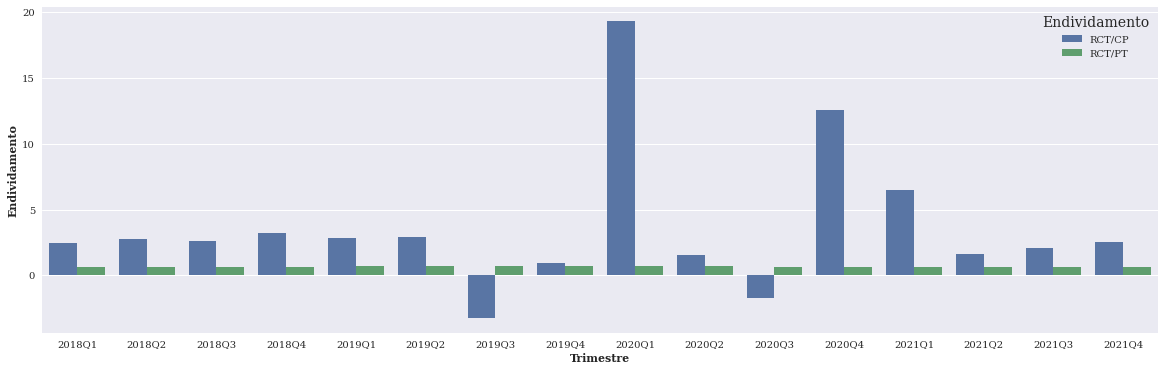

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,RCT/CP,RCT/PT
mean,1.814030,0.673794
std,2.155927,0.007137
min,-3.239751,0.666326
25%,2.073835,0.667692
50%,2.675245,0.673159
75%,2.874285,0.678240
max,3.248520,0.685973


Estatísticas Descritivas - Pandemia


,RCT/CP,RCT/PT
mean,5.555699,0.663216
std,7.013326,0.022261
min,-1.748931,0.638781
25%,1.613019,0.647697
50%,2.318859,0.657723
75%,8.024595,0.672008
max,19.297364,0.701611


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-1.442377,0.171193
1,RCT/CP,Teste H,0.044118,0.833635
2,RCT/PT,Teste t,1.279849,0.221401
3,RCT/PT,Teste H,2.823529,0.092892


2.1) Teste de hipótese amostral


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-8.848683,0.0
1,RCT/CP,Teste H,38.069886,0.0
2,RCT/PT,Teste t,6.91071,0.0
3,RCT/PT,Teste H,34.58089,0.0



 COMUNICAÇÕES
1) Endividamento Setorial


,RCT/CP,RCT/PT
DT_REFER,,
2018Q1,0.754619,0.430076
2018Q2,0.692560,0.409179
2018Q3,0.574785,0.364993
2018Q4,0.614456,0.380596
2019Q1,0.848588,0.459047
2019Q2,0.750091,0.428601
2019Q3,0.787944,0.440698
2019Q4,0.798736,0.444054
2020Q1,0.748747,0.428162


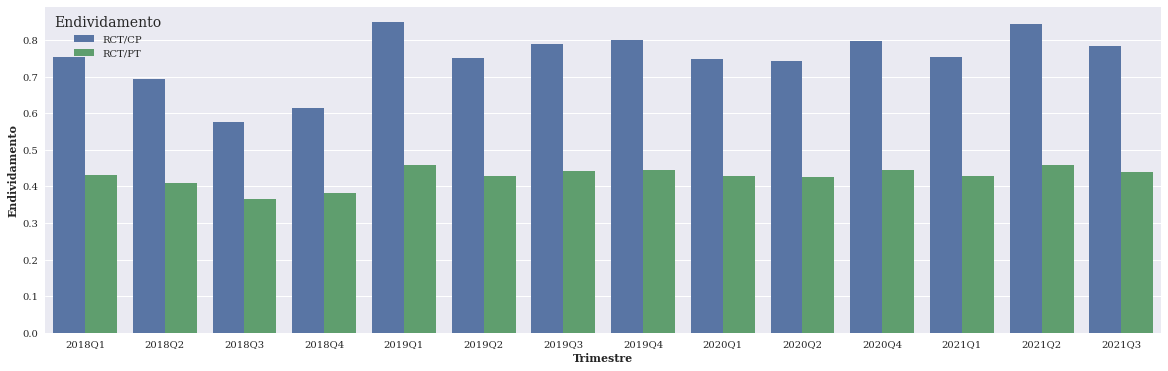

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,RCT/CP,RCT/PT
mean,0.727722,0.419655
std,0.094080,0.032518
min,0.574785,0.364993
25%,0.673034,0.402033
50%,0.752355,0.429338
75%,0.790642,0.441537
max,0.848588,0.459047


Estatísticas Descritivas - Pandemia


,RCT/CP,RCT/PT
mean,0.778448,0.437491
std,0.038900,0.012119
min,0.743329,0.426385
25%,0.749653,0.428458
50%,0.768541,0.434515
75%,0.793767,0.442509
max,0.844744,0.457919


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-1.233986,0.24083
1,RCT/CP,Teste H,0.266667,0.605577
2,RCT/PT,Teste t,-1.268316,0.228739
3,RCT/PT,Teste H,0.266667,0.605577


2.1) Teste de hipótese amostral


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-8.040912,0.0
1,RCT/CP,Teste H,38.070114,0.0
2,RCT/PT,Teste t,-8.794389,0.0
3,RCT/PT,Teste H,47.623279,0.0



 CONSUMO CÍCLICO
1) Endividamento Setorial


,RCT/CP,RCT/PT
DT_REFER,,
2018Q1,1.604648,0.657411
2018Q2,1.891715,0.669595
2018Q3,-0.717059,0.695992
2018Q4,1.830709,0.719166
2019Q1,2.083445,0.754950
2019Q2,0.912523,0.768595
2019Q3,1.827094,0.765709
2019Q4,3.000738,0.773020
2020Q1,2.213009,0.781041


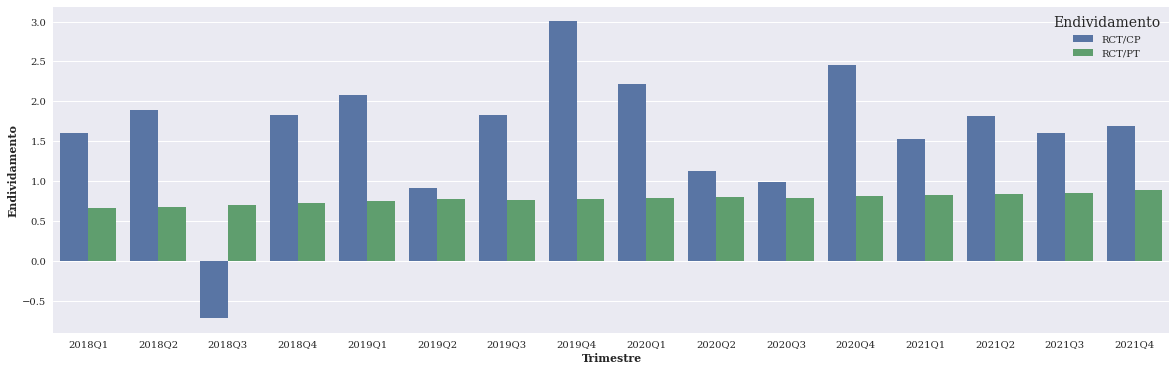

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,RCT/CP,RCT/PT
mean,1.554227,0.725555
std,1.083007,0.046708
min,-0.717059,0.657411
25%,1.431617,0.689393
50%,1.828902,0.737058
75%,1.939648,0.766430
max,3.000738,0.773020


Estatísticas Descritivas - Pandemia


,RCT/CP,RCT/PT
mean,1.676304,0.822705
std,0.493635,0.035389
min,0.988867,0.781041
25%,1.423649,0.794924
50%,1.646563,0.819494
75%,1.912315,0.843062
max,2.450637,0.884643


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-0.290108,0.775986
1,RCT/CP,Teste H,0.176471,0.674424
2,RCT/PT,Teste t,-4.689063,0.000348
3,RCT/PT,Teste H,11.294118,0.000778


2.1) Teste de hipótese amostral


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,0.006197,0.995081
1,RCT/CP,Teste H,1.939281,0.163747
2,RCT/PT,Teste t,-25.237334,0.0
3,RCT/PT,Teste H,74.259654,0.0



 CONSUMO NÃO CÍCLICO
1) Endividamento Setorial


,RCT/CP,RCT/PT
DT_REFER,,
2018Q1,-1.388706,0.705366
2018Q2,3.428301,0.733036
2018Q3,3.674624,0.733979
2018Q4,2.074984,0.732903
2019Q1,2.377761,0.733248
2019Q2,2.268339,0.724972
2019Q3,2.759820,0.733881
2019Q4,3.258011,0.749587
2020Q1,10.776323,0.776122


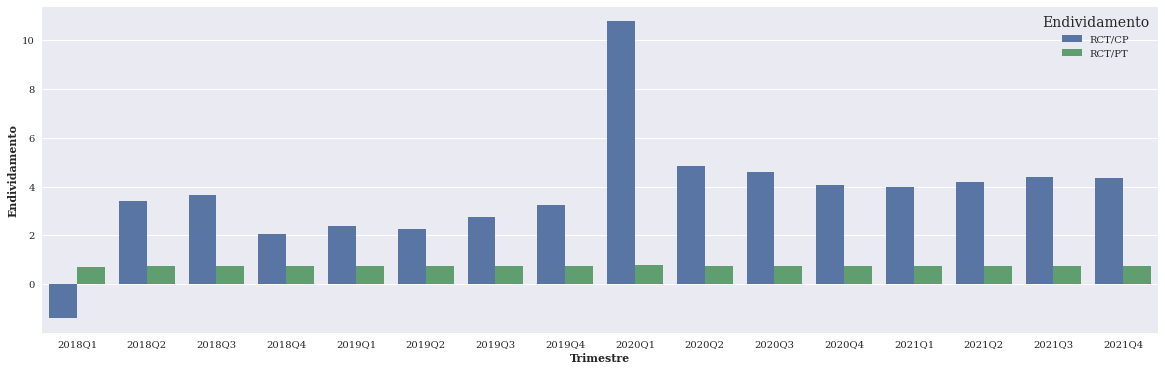

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,RCT/CP,RCT/PT
mean,2.306642,0.730871
std,1.601595,0.012357
min,-1.388706,0.705366
25%,2.220001,0.730920
50%,2.568791,0.733142
75%,3.300584,0.733905
max,3.674624,0.749587


Estatísticas Descritivas - Pandemia


,RCT/CP,RCT/PT
mean,5.145208,0.751712
std,2.292768,0.013767
min,3.977474,0.736722
25%,4.145308,0.741416
50%,4.360857,0.749622
75%,4.665427,0.758510
max,10.776323,0.776122


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-2.870701,0.012336
1,RCT/CP,Teste H,11.294118,0.000778
2,RCT/PT,Teste t,-3.186535,0.006595
3,RCT/PT,Teste H,8.647059,0.003276


2.1) Teste de hipótese amostral


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-15.215426,0.0
1,RCT/CP,Teste H,74.259208,0.0
2,RCT/PT,Teste t,-16.518148,0.0
3,RCT/PT,Teste H,73.903635,0.0



 FINANCEIRO
1) Endividamento Setorial


,RCT/CP,RCT/PT
DT_REFER,,
2018Q1,1.418828,0.471557
2018Q2,1.445840,0.487715
2018Q3,1.454277,0.479123
2018Q4,1.551860,0.509530
2019Q1,1.114168,0.409410
2019Q2,1.084479,0.425090
2019Q3,1.053947,0.419574
2019Q4,1.673427,0.516929
2020Q1,1.186324,0.430930


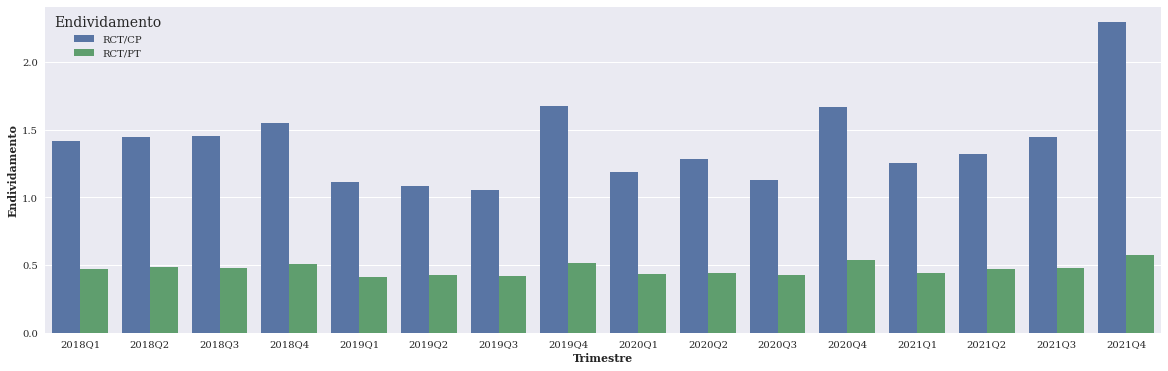

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,RCT/CP,RCT/PT
mean,1.349603,0.464866
std,0.234190,0.041721
min,1.053947,0.409410
25%,1.106745,0.423711
50%,1.432334,0.475340
75%,1.478673,0.493169
max,1.673427,0.516929


Estatísticas Descritivas - Pandemia


,RCT/CP,RCT/PT
mean,1.448816,0.475903
std,0.381116,0.053524
min,1.126607,0.430550
25%,1.240502,0.437916
50%,1.303420,0.456969
75%,1.503809,0.493306
max,2.295746,0.574509


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-0.62733,0.54054
1,RCT/CP,Teste H,0.099265,0.752714
2,RCT/PT,Teste t,-0.45999,0.652586
3,RCT/PT,Teste H,0.099265,0.752714


2.1) Teste de hipótese amostral


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-3.305148,0.00178
1,RCT/CP,Teste H,7.008104,0.008114
2,RCT/PT,Teste t,-3.187392,0.002501
3,RCT/PT,Teste H,7.95037,0.004808



 MATERIAIS BÁSICOS
1) Endividamento Setorial


,RCT/CP,RCT/PT
DT_REFER,,
2018Q1,1.157671,0.526534
2018Q2,1.304229,0.538396
2018Q3,1.374999,0.542706
2018Q4,1.362743,0.530083
2019Q1,1.572124,0.573224
2019Q2,1.567041,0.578468
2019Q3,1.653394,0.580590
2019Q4,1.747274,0.603773
2020Q1,4.931843,0.648057


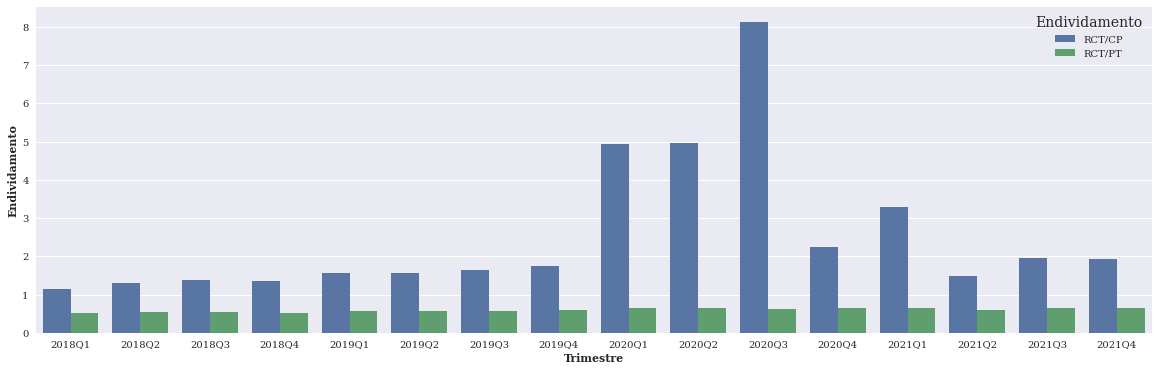

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,RCT/CP,RCT/PT
mean,1.467434,0.559222
std,0.198518,0.028365
min,1.157671,0.526534
25%,1.348115,0.536318
50%,1.471020,0.557965
75%,1.592442,0.578999
max,1.747274,0.603773


Estatísticas Descritivas - Pandemia


,RCT/CP,RCT/PT
mean,3.612969,0.639174
std,2.266877,0.017647
min,1.494418,0.599269
25%,1.943618,0.637905
50%,2.765268,0.642543
75%,4.937406,0.648480
max,8.120213,0.657866


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-2.66682,0.018414
1,RCT/CP,Teste H,8.647059,0.003276
2,RCT/PT,Teste t,-6.769368,0.000009
3,RCT/PT,Teste H,10.599265,0.001131


2.1) Teste de hipótese amostral


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-15.67454,0.0
1,RCT/CP,Teste H,74.261436,0.0
2,RCT/PT,Teste t,-36.637668,0.0
3,RCT/PT,Teste H,74.258763,0.0



 PETRÓLEO. GÁS E BIOCOMBUSTÍVEIS
1) Endividamento Setorial


,RCT/CP,RCT/PT
DT_REFER,,
2018Q1,1.500131,0.530700
2018Q2,1.555553,0.559797
2018Q3,1.519919,0.536346
2018Q4,1.484722,0.544302
2019Q1,2.312087,0.671623
2019Q2,2.226705,0.666099
2019Q3,2.192259,0.662835
2019Q4,1.949284,0.642108
2020Q1,2.178246,0.658167


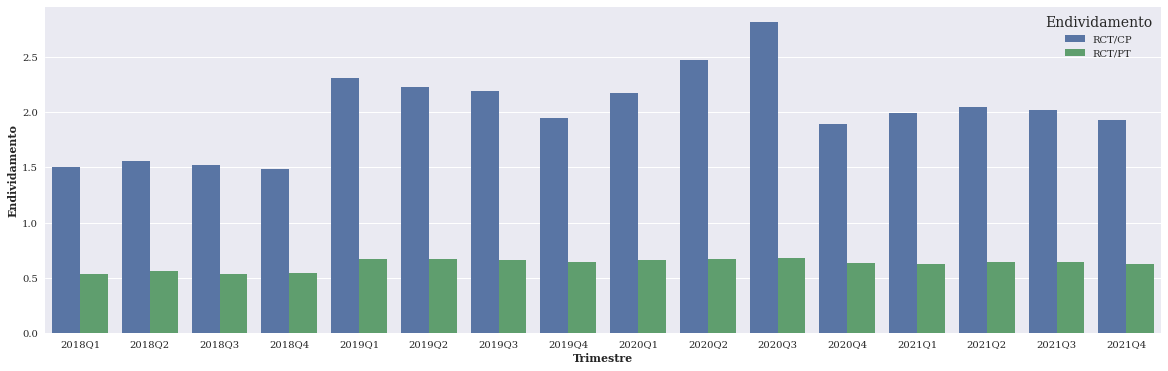

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,RCT/CP,RCT/PT
mean,1.842582,0.601726
std,0.365177,0.064108
min,1.484722,0.530700
25%,1.514972,0.542313
50%,1.752418,0.600952
75%,2.200870,0.663651
max,2.312087,0.671623


Estatísticas Descritivas - Pandemia


,RCT/CP,RCT/PT
mean,2.169172,0.648565
std,0.319482,0.020379
min,1.890091,0.626372
25%,1.976269,0.633502
50%,2.035601,0.643517
75%,2.252235,0.661492
max,2.816786,0.682322


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-1.903805,0.077696
1,RCT/CP,Teste H,1.588235,0.207578
2,RCT/PT,Teste t,-1.969402,0.069024
3,RCT/PT,Teste H,1.102941,0.293622


2.1) Teste de hipótese amostral


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-11.16546,0.0
1,RCT/CP,Teste H,61.117675,0.0
2,RCT/PT,Teste t,-10.610292,0.0
3,RCT/PT,Teste H,66.850534,0.0



 SAÚDE
1) Endividamento Setorial


,RCT/CP,RCT/PT
DT_REFER,,
2018Q1,0.837905,0.437088
2018Q2,0.846038,0.438345
2018Q3,0.854718,0.442794
2018Q4,1.005572,0.479530
2019Q1,1.269638,0.521874
2019Q2,1.224925,0.514850
2019Q3,1.344844,0.538425
2019Q4,1.479830,0.566672
2020Q1,1.627634,0.585839


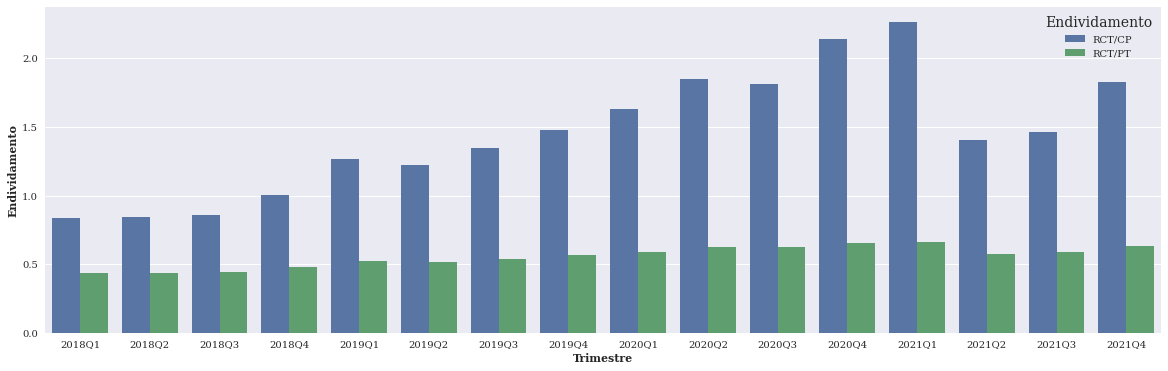

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,RCT/CP,RCT/PT
mean,1.107934,0.492447
std,0.253650,0.050164
min,0.837905,0.437088
25%,0.852548,0.441682
50%,1.115248,0.497190
75%,1.288439,0.526012
max,1.479830,0.566672


Estatísticas Descritivas - Pandemia


,RCT/CP,RCT/PT
mean,1.797874,0.618700
std,0.300050,0.032692
min,1.406843,0.576778
25%,1.586046,0.585768
50%,1.817833,0.625673
75%,1.922996,0.637913
max,2.262917,0.663799


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-4.966803,0.000207
1,RCT/CP,Teste H,9.926471,0.001629
2,RCT/PT,Teste t,-5.963866,0.000035
3,RCT/PT,Teste H,11.294118,0.000778


2.1) Teste de hipótese amostral


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-28.498669,0.0
1,RCT/CP,Teste H,74.260991,0.0
2,RCT/PT,Teste t,-30.539978,0.0
3,RCT/PT,Teste H,74.261882,0.0



 TECNOLOGIA DA INFORMAÇÃO
1) Endividamento Setorial


,RCT/CP,RCT/PT
DT_REFER,,
2018Q1,5.325196,0.542489
2018Q2,1.582977,0.525143
2018Q3,1.634776,0.524912
2018Q4,1.260066,0.520222
2019Q1,1.467123,0.566426
2019Q2,1.209651,0.473995
2019Q3,0.857440,0.391792
2019Q4,0.862626,0.384389
2020Q1,0.726578,0.370489


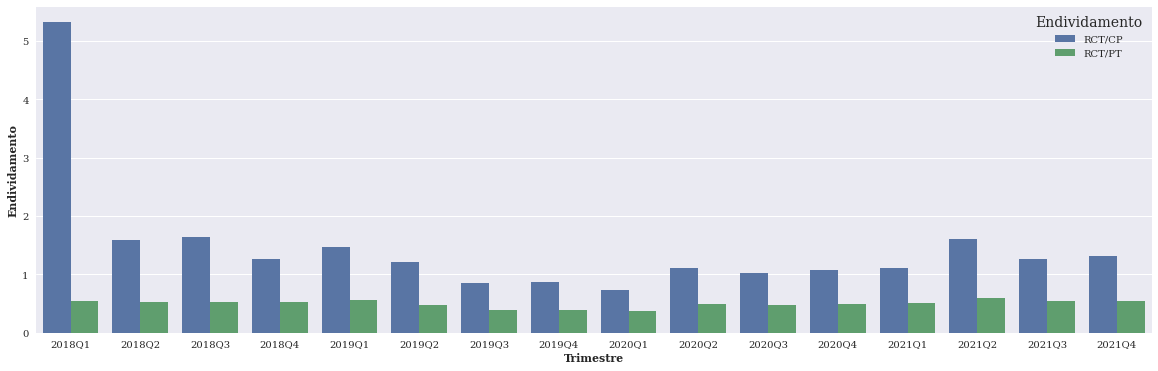

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,RCT/CP,RCT/PT
mean,1.774982,0.491171
std,1.464549,0.068668
min,0.857440,0.384389
25%,1.122895,0.453445
50%,1.363594,0.522567
75%,1.595927,0.529479
max,5.325196,0.566426


Estatísticas Descritivas - Pandemia


,RCT/CP,RCT/PT
mean,1.155162,0.505739
std,0.252915,0.066171
min,0.726578,0.370489
25%,1.066970,0.491729
50%,1.113848,0.506508
75%,1.270502,0.542182
max,1.608693,0.598866


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,1.179574,0.257827
1,RCT/CP,Teste H,1.334559,0.247996
2,RCT/PT,Teste t,-0.432096,0.672253
3,RCT/PT,Teste H,0.011029,0.916359


2.1) Teste de hipótese amostral


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,5.580254,0.000001
1,RCT/CP,Teste H,26.876728,0.0
2,RCT/PT,Teste t,-2.048188,0.045919
3,RCT/PT,Teste H,3.066217,0.079935



 UTILIDADE PÚBLICA
1) Endividamento Setorial


,RCT/CP,RCT/PT
DT_REFER,,
2018Q1,1.399077,0.467364
2018Q2,1.511645,0.480050
2018Q3,1.583708,0.487055
2018Q4,1.683228,0.492645
2019Q1,1.729532,0.494009
2019Q2,1.684500,0.489418
2019Q3,1.586019,0.488033
2019Q4,1.613957,0.492575
2020Q1,1.608702,0.489195


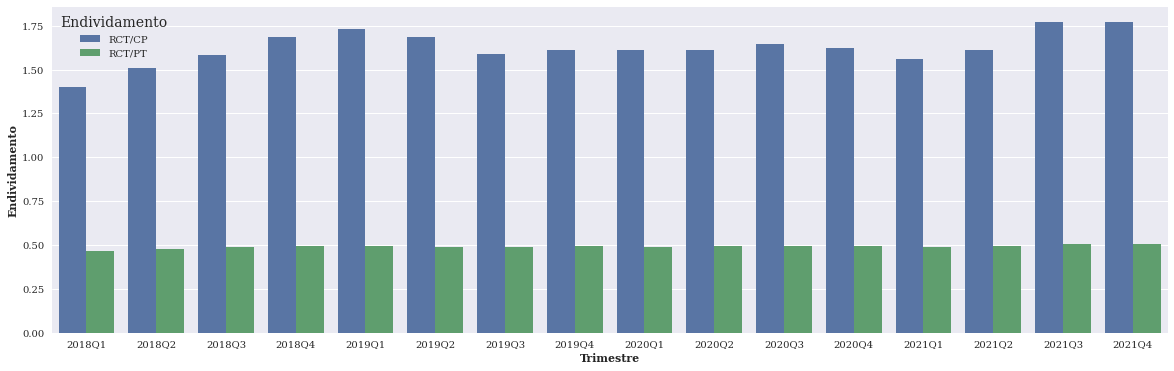

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,RCT/CP,RCT/PT
mean,1.598958,0.486394
std,0.106683,0.008863
min,1.399077,0.467364
25%,1.565693,0.485304
50%,1.599988,0.488726
75%,1.683546,0.492593
max,1.729532,0.494009


Estatísticas Descritivas - Pandemia


,RCT/CP,RCT/PT
mean,1.650050,0.496570
std,0.077336,0.006364
min,1.560875,0.489195
25%,1.609610,0.492981
50%,1.617394,0.495066
75%,1.677919,0.499107
max,1.769936,0.506702


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-1.096715,0.291273
1,RCT/CP,Teste H,0.705882,0.400814
2,RCT/PT,Teste t,-2.638032,0.019479
3,RCT/PT,Teste H,6.352941,0.011719


2.1) Teste de hipótese amostral


,Endividamento,Teste,Estatística,Valor p
0,RCT/CP,Teste t,-7.151131,0.0
1,RCT/CP,Teste H,35.234057,0.0
2,RCT/PT,Teste t,-12.044166,0.0
3,RCT/PT,Teste H,70.044312,0.0


In [29]:
setores = lista_setores()

for nome in list(setores.keys()):
    print('\n', nome.upper())
    setor = setores[nome]

    print('1) Endividamento Setorial')
    endividamento_setorial = calcula_endividamento_setorial(dfcs, setor, nome=nome)
    endividamento_setorial = endividamento_setorial['2018-01-01':]
    display(endividamento_setorial)
    
    plot_endividamento(endividamento_setorial, nome=nome)
    
    print('2) Testes de Hipótese')
    
    endividamento_stats = calcula_endividamento_testes(endividamento_setorial, nome=nome)
    display(endividamento_stats)
    
    print('2.1) Teste de hipótese amostral')
    endividamento_stats_amostral = calcula_endividamento_teste_amostral(endividamento_setorial, nome=nome)
    display(endividamento_stats_amostral)


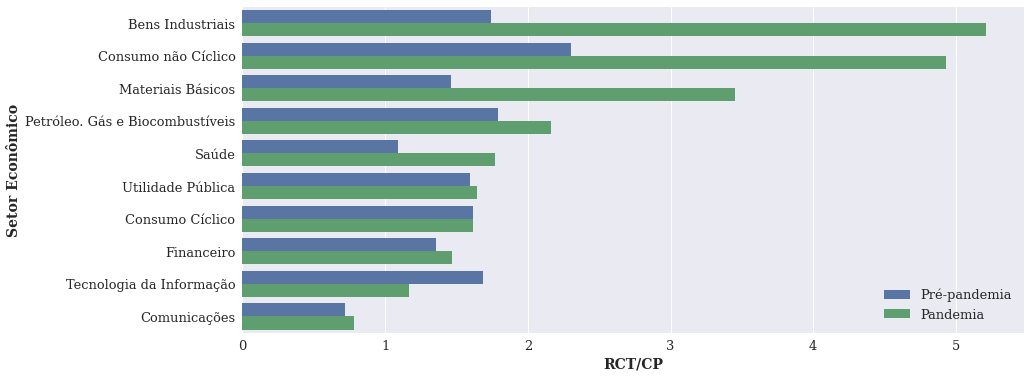

In [35]:
RCT_CP = calcula_RCT_CP(setores)
grouped = RCT_CP.groupby('Setor Econômico')
pandemia = grouped['RCT/CP'].last()
pandemia = pandemia.to_list()
lst_pan = []
for p in pandemia:
    lst_pan.append(p)
    lst_pan.append(p)

RCT_CP['Pan'] = lst_pan
tmp = RCT_CP.sort_values(['Pan', 'Período'], ascending=False)
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=tmp, x = 'RCT/CP', y = 'Setor Econômico', hue='Período')
#ax.axvline(1, color='red', alpha=.5, linestyle='dashed')

ax.set_xlabel('RCT/CP', fontweight='bold', fontsize=14)
ax.set_ylabel('Setor Econômico', fontweight='bold', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=13)
plt.legend(prop={'size': 13})

plt.savefig(os.path.join(ROOT_DIR, 'img', 'indicadores', 'rct_cp_setores.png'), bbox_inches='tight')
plt.show()

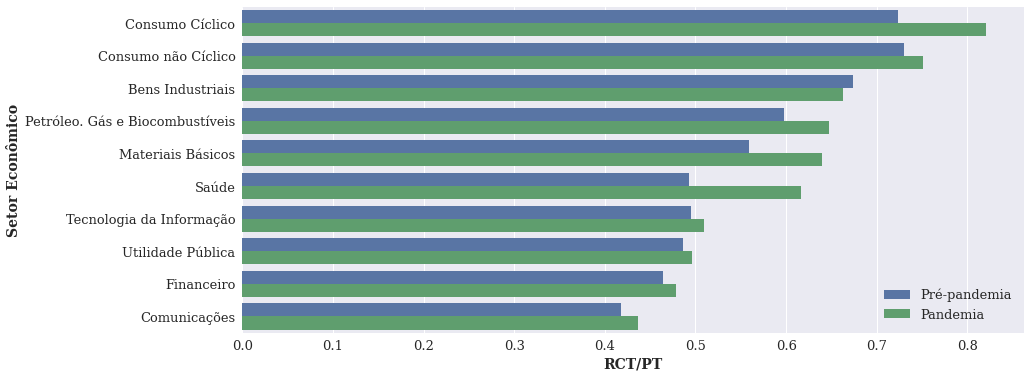

In [36]:
RCT_PT = calcula_RCT_PT(setores)
grouped = RCT_PT.groupby('Setor Econômico')
pandemia = grouped['RCT/PT'].last()
pandemia = pandemia.to_list()
lst_pan = []
for p in pandemia:
    lst_pan.append(p)
    lst_pan.append(p)

RCT_PT['Pan'] = lst_pan
tmp = RCT_PT.sort_values(['Pan', 'Período'], ascending=False)
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=tmp, x = 'RCT/PT', y = 'Setor Econômico', hue='Período')
#ax.axvline(1, color='red', alpha=.5, linestyle='dashed')

ax.set_xlabel('RCT/PT', fontweight='bold', fontsize=14)
ax.set_ylabel('Setor Econômico', fontweight='bold', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=13)
plt.legend(prop={'size': 13})

plt.savefig(os.path.join(ROOT_DIR, 'img', 'indicadores', 'rct_pt_setores.png'), bbox_inches='tight')
plt.show()